In [3]:
from billiard import BilliardModel
from matplotlib import pyplot as plt
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

class MolecularDynamicsSimulator:
    def __init__(self, number_of_particles=200, dimensions=2, size=1000, temperature=200, radius=10, delta_t=0.5):
        self.billiard_model = BilliardModel(
            number_of_particles=number_of_particles,
            dimensions=dimensions,
            size=size,
            temperature=temperature,
            radius=radius,
            delta_t=delta_t
        )
        self.frames = []

    def animate_simulation_3d(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        spheres = [ax.plot([], [], [], 'o', markersize=self.billiard_model.radius)[0] for _ in range(self.billiard_model.N)]
        
        text_properties = {
            'horizontalalignment': 'left',
            'verticalalignment': 'center',
            'fontsize': 9,
            'bbox': {'facecolor': 'white', 'alpha': 0.7, 'pad': 4}
        }

        temp_text = ax.text2D(0.01, 0.97, '', transform=ax.transAxes, **text_properties)
        pressure_text = ax.text2D(0.01, 0.88, '', transform=ax.transAxes, **text_properties)
        energy_text = ax.text2D(0.01, 0.1, '', transform=ax.transAxes, **text_properties)
        ratio_text = ax.text2D(0.01, 0, '', transform=ax.transAxes, **text_properties)

        ax.set_xlim(0, self.billiard_model.size)
        ax.set_ylim(0, self.billiard_model.size)
        ax.set_zlim(0, self.billiard_model.size)

        def init():
            for sphere in spheres:
                sphere.set_data([], [])
                sphere.set_3d_properties([])
            temp_text.set_text('')
            pressure_text.set_text('')
            energy_text.set_text('')
            return spheres + [temp_text, pressure_text, energy_text]

        def update(frame_data):
            for sphere, position in zip(spheres, frame_data["positions"]):
                sphere.set_data(position[0], position[1])
                sphere.set_3d_properties(position[2])
            temp_text.set_text('Temperature: {:.2f} K'.format(frame_data["temperature"]))
            pressure_text.set_text('Pressure: {:.2e} Pa'.format(frame_data["pressure"]))
            energy_text.set_text('Total Energy: {:.2e} J'.format(frame_data["total_energy"]))
            pv = frame_data["pressure"] * self.billiard_model.get_shape()
            NKT = self.billiard_model.N * self.billiard_model.k_B * frame_data["temperature"]
            ratio = pv / NKT
            ratio_text.set_text('PV/NkT: {:.5f}'.format(ratio))

            return spheres + [temp_text, pressure_text, energy_text, ratio_text]

        ani = FuncAnimation(fig, update, frames=self.frames, init_func=init, blit=False, interval=50)

        gif_path_3d = 'billiard_simulation_3d.gif'
        ani.save(gif_path_3d, writer='pillow')
        print("3D GIF saved at:", gif_path_3d)
        return fig, ani
    
    def run_tk(self):
        # Create main window
        root = tk.Tk()
        root.wm_title("Billiard Model Simulation")


        delta_t_slider = tk.Scale(root, from_=0.001, to=10, resolution=0.001, orient=tk.HORIZONTAL, label="Delta t")
        delta_t_slider.set(self.billiard_model.delta_t)
        delta_t_slider.pack()

        mass_slider = tk.Scale(root, from_=1e-26, to=1e-19, resolution=1e-23, orient=tk.HORIZONTAL, label="Mass")
        mass_slider.set(self.billiard_model.mass)
        mass_slider.pack()

        radius_slider = tk.Scale(root, from_=1, to=50, resolution=1, orient=tk.HORIZONTAL, label="Radius")
        radius_slider.set(self.billiard_model.radius)
        radius_slider.pack()

        temperature_slider = tk.Scale(root, from_=10, to=1000, resolution=10, orient=tk.HORIZONTAL, label="Temperature")
        temperature_slider.set(self.billiard_model.temperature)
        temperature_slider.pack()

        # Create a figure for the plot
        fig = Figure(figsize=(5, 4), dpi=100)
        ax = fig.add_subplot(111)

        # Code for creating circles and texts
        circles = [Circle((0, 0), self.billiard_model.radius, color='blue', fill=True) for _ in range(self.billiard_model.N)]
        for circle in circles:
            ax.add_patch(circle)

        temp_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
        pressure_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)
        energy_text = ax.text(0.02, 0.85, '', transform=ax.transAxes)
        ratio_text = ax.text(0.02, 0.80, '', transform=ax.transAxes)

        ax.set_xlim(0, self.billiard_model.size)
        ax.set_ylim(0, self.billiard_model.size)
        ax.set_aspect('equal', 'box')

        # Initialization function
        def init():
            for circle in circles:
                circle.center = (0, 0)
            temp_text.set_text('')
            pressure_text.set_text('')
            energy_text.set_text('')
            return circles + [temp_text, pressure_text, energy_text]

        frame_generator = self.billiard_model.real_time_simulation()  # Get the generator

        # Update function
        def update(_):
            try:
                self.billiard_model.update_delta_t(delta_t_slider.get())
                self.billiard_model.update_mass(mass_slider.get())
                self.billiard_model.update_radius(radius_slider.get())
                self.billiard_model.update_temperature(temperature_slider.get())
                
                frame_data = next(frame_generator)
                for circle, position in zip(circles, frame_data["positions"]):
                    circle.center = position
                    circle.radius = self.billiard_model.radius
                    
                temp_text.set_text('Temperature: {:.2f} K'.format(frame_data["temperature"]))
                pressure_text.set_text('Pressure: {:.2e} Pa'.format(frame_data["pressure"]))
                energy_text.set_text('Total Energy: {:.2e} J'.format(frame_data["total_energy"]))
                pv = frame_data["pressure"] * self.billiard_model.get_shape()
                NKT = self.billiard_model.N * self.billiard_model.k_B * frame_data["temperature"]
                ratio = pv / NKT
                ratio_text.set_text('PV/NkT: {:.5f}'.format(ratio))

                return circles + [temp_text, pressure_text, energy_text, ratio_text]
            except StopIteration:
                return  # If no more frames, end the animation
            
        # Flag to control animation
        self.is_animating = False

        # Function to toggle animation
        def toggle_animation():
            self.is_animating = not self.is_animating

        # Start Button
        start_button = tk.Button(root, text="Start/Stop Simulation", command=toggle_animation)
        start_button.pack()

        # Embedding the figure in the Tkinter window
        canvas = FigureCanvasTkAgg(fig, master=root)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=1)
        if self.is_animating:
            ani = FuncAnimation(fig, update, init_func=init, blit=False, interval=50)
        tk.mainloop()
        ax = fig.add_subplot(111, projection='3d')

        spheres = [ax.plot([], [], [], 'o', markersize=self.billiard_model.radius)[0] for _ in range(self.billiard_model.N)]
        
        text_properties = {
            'horizontalalignment': 'left',
            'verticalalignment': 'center',
            'fontsize': 9,
            'bbox': {'facecolor': 'white', 'alpha': 0.7, 'pad': 4}
        }

        temp_text = ax.text2D(0.01, 0.97, '', transform=ax.transAxes, **text_properties)
        pressure_text = ax.text2D(0.01, 0.88, '', transform=ax.transAxes, **text_properties)
        energy_text = ax.text2D(0.01, 0.1, '', transform=ax.transAxes, **text_properties)
        ratio_text = ax.text2D(0.01, 0, '', transform=ax.transAxes, **text_properties)

        ax.set_xlim(0, self.billiard_model.size)
        ax.set_ylim(0, self.billiard_model.size)
        ax.set_zlim(0, self.billiard_model.size)

        def init():
            for sphere in spheres:
                sphere.set_data([], [])
                sphere.set_3d_properties([])
            temp_text.set_text('')
            pressure_text.set_text('')
            energy_text.set_text('')
            return spheres + [temp_text, pressure_text, energy_text]

        def update(frame_data):
            for sphere, position in zip(spheres, frame_data["positions"]):
                sphere.set_data(position[0], position[1])
                sphere.set_3d_properties(position[2])
            temp_text.set_text('Temperature: {:.2f} K'.format(frame_data["temperature"]))
            pressure_text.set_text('Pressure: {:.2e} Pa'.format(frame_data["pressure"]))
            energy_text.set_text('Total Energy: {:.2e} J'.format(frame_data["total_energy"]))
            pv = frame_data["pressure"] * self.billiard_model.get_shape()
            NKT = self.billiard_model.N * self.billiard_model.k_B * frame_data["temperature"]
            ratio = pv / NKT
            ratio_text.set_text('PV/NkT: {:.5f}'.format(ratio))

            return spheres + [temp_text, pressure_text, energy_text, ratio_text]

        ani = FuncAnimation(fig, update, frames=self.frames, init_func=init, blit=False, interval=50)

        gif_path_3d = 'billiard_simulation_3d.gif'
        ani.save(gif_path_3d, writer='pillow')
        print("3D GIF saved at:", gif_path_3d)
        return fig, ani
    
    def run_tk(self):
        # Create main window
        root = tk.Tk()
        root.wm_title("Billiard Model Simulation")


        delta_t_slider = tk.Scale(root, from_=0.001, to=10, resolution=0.001, orient=tk.HORIZONTAL, label="Delta t")
        delta_t_slider.set(self.billiard_model.delta_t)
        delta_t_slider.pack()

        mass_slider = tk.Scale(root, from_=1e-26, to=1e-19, resolution=1e-23, orient=tk.HORIZONTAL, label="Mass")
        mass_slider.set(self.billiard_model.mass)
        mass_slider.pack()

        radius_slider = tk.Scale(root, from_=1, to=50, resolution=1, orient=tk.HORIZONTAL, label="Radius")
        radius_slider.set(self.billiard_model.radius)
        radius_slider.pack()

        temperature_slider = tk.Scale(root, from_=10, to=1000, resolution=10, orient=tk.HORIZONTAL, label="Temperature")
        temperature_slider.set(self.billiard_model.temperature)
        temperature_slider.pack()

        # Create a figure for the plot
        fig = Figure(figsize=(5, 4), dpi=100)
        ax = fig.add_subplot(111)

        # Code for creating circles and texts
        circles = [Circle((0, 0), self.billiard_model.radius, color='blue', fill=True) for _ in range(self.billiard_model.N)]
        for circle in circles:
            ax.add_patch(circle)

        temp_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
        pressure_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)
        energy_text = ax.text(0.02, 0.85, '', transform=ax.transAxes)
        ratio_text = ax.text(0.02, 0.80, '', transform=ax.transAxes)

        ax.set_xlim(0, self.billiard_model.size)
        ax.set_ylim(0, self.billiard_model.size)
        ax.set_aspect('equal', 'box')

        # Initialization function
        def init():
            for circle in circles:
                circle.center = (0, 0)
            temp_text.set_text('')
            pressure_text.set_text('')
            energy_text.set_text('')
            return circles + [temp_text, pressure_text, energy_text]

        frame_generator = self.billiard_model.real_time_simulation()  # Get the generator
        # Flag to control animation
        self.is_animating = False
        # Update function
        def update(_):
            if self.is_animating:
                self.billiard_model.update_delta_t(delta_t_slider.get())
                self.billiard_model.update_mass(mass_slider.get())
                self.billiard_model.update_radius(radius_slider.get())
                self.billiard_model.update_temperature(temperature_slider.get())
                
                frame_data = next(frame_generator)
                for circle, position in zip(circles, frame_data["positions"]):
                    circle.center = position
                    circle.radius = self.billiard_model.radius
                    
                temp_text.set_text('Temperature: {:.2f} K'.format(frame_data["temperature"]))
                pressure_text.set_text('Pressure: {:.2e} Pa'.format(frame_data["pressure"]))
                energy_text.set_text('Total Energy: {:.2e} J'.format(frame_data["total_energy"]))
                pv = frame_data["pressure"] * self.billiard_model.get_shape()
                NKT = self.billiard_model.N * self.billiard_model.k_B * frame_data["temperature"]
                ratio = pv / NKT
                ratio_text.set_text('PV/NkT: {:.5f}'.format(ratio))
            return circles + [temp_text, pressure_text, energy_text, ratio_text]

        # Function to toggle animation
        def toggle_animation():
            self.is_animating = not self.is_animating

        # Start Button
        start_button = tk.Button(root, text="Start/Stop Simulation", command=toggle_animation)
        start_button.pack()

        # Embedding the figure in the Tkinter window
        canvas = FigureCanvasTkAgg(fig, master=root)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=1)
        ani = FuncAnimation(fig, update, init_func=init, blit=False, interval=50)
        tk.mainloop()

In [4]:
sim = MolecularDynamicsSimulator()

sim.run_tk()

/var/folders/xh/z5gsc60d3_g6xpyqpzc139f40000gn/T/ipykernel_51205/4201142803.py:303: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, init_func=init, blit=False, interval=50)


/var/folders/xh/z5gsc60d3_g6xpyqpzc139f40000gn/T/ipykernel_51308/3159691361.py:83: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.ani = FuncAnimation(self.fig, self.update_2d, init_func=self.init_2d, blit=False, interval=50)
/var/folders/xh/z5gsc60d3_g6xpyqpzc139f40000gn/T/ipykernel_51308/3159691361.py:94: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.ani = FuncAnimation(self.fig, self.update_3d, init_func=self.init_3d, blit=False, interval=50)
/var/folders/xh/z5gsc60d3_g6xpyqpzc1

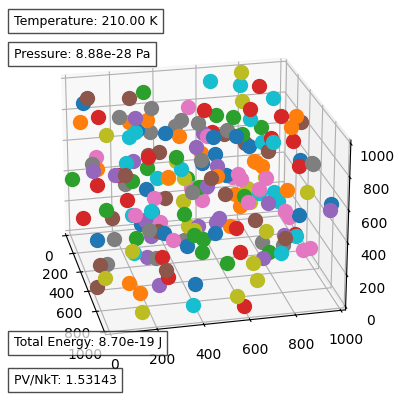

In [4]:
from billiard import BilliardModel
from matplotlib import pyplot as plt
import tkinter as tk
from tkinter import ttk  # Import ttk module
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

class MolecularDynamicsSimulator:
    def __init__(self, number_of_particles=200, size=1000, temperature=200, radius=10, delta_t=0.5):
        self.N = number_of_particles
        self.size = size
        self.temperature = temperature
        self.radius = radius
        self.delta_t = delta_t
        self.ani = None
    
    def init_model(self, dimensions):
        self.billiard_model = BilliardModel(number_of_particles=self.N, 
                                            dimensions=dimensions, 
                                            size=self.size, 
                                            temperature=self.temperature, 
                                            delta_t=self.delta_t, 
                                            radius=self.radius)
        self.frame_generator = self.billiard_model.real_time_simulation()  # Get the generator
    
    def run_tk(self):
        # Create main window
        self.root = tk.Tk()
        self.root.wm_title("Billiard Model Simulation")
        self.init_model(dimensions=2)

        self.mode_var = tk.StringVar()  # Variable to store the selection
        mode_combobox = ttk.Combobox(self.root, textvariable=self.mode_var, state="readonly")
        mode_combobox['values'] = ('2D', '3D')
        mode_combobox.current(0)  # Set default value to '2D'
        mode_combobox.pack()

        self.delta_t_slider = tk.Scale(self.root, from_=0.001, to=10, resolution=0.001, orient=tk.HORIZONTAL, label="Delta t")
        self.delta_t_slider.set(self.billiard_model.delta_t)
        self.delta_t_slider.pack()

        self.mass_slider = tk.Scale(self.root, from_=1e-26, to=1e-19, resolution=1e-23, orient=tk.HORIZONTAL, label="Mass")
        self.mass_slider.set(self.billiard_model.mass)
        self.mass_slider.pack()

        self.radius_slider = tk.Scale(self.root, from_=1, to=50, resolution=1, orient=tk.HORIZONTAL, label="Radius")
        self.radius_slider.set(self.billiard_model.radius)
        self.radius_slider.pack()

        self.temperature_slider = tk.Scale(self.root, from_=10, to=1000, resolution=10, orient=tk.HORIZONTAL, label="Temperature")
        self.temperature_slider.set(self.billiard_model.temperature)
        self.temperature_slider.pack()

        # Flag to control animation
        self.is_animating = False

        # Function to toggle animation
        def toggle_animation():
            self.is_animating = not self.is_animating

        # Bind the selection change event
        mode_combobox.bind('<<ComboboxSelected>>', self.on_mode_change)

        # Start Button
        start_button = tk.Button(self.root, text="Start/Stop Simulation", command=toggle_animation)
        start_button.pack()
        if self.mode_var.get() == '2D':
            self.ani, self.canvas = self.simulate_2d()
        else:
            self.ani, self.canvas = self.simulate_3d()
        tk.mainloop()

    def simulate_2d(self):
        if hasattr(self, 'canvas'):
            self.canvas.get_tk_widget().destroy()
        # Embedding the figure in the Tkinter window
        self.create_2d_fig()
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.root)
        canvas_widget = self.canvas.get_tk_widget()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=1)
        self.ani = FuncAnimation(self.fig, self.update_2d, init_func=self.init_2d, blit=False, interval=50)
        return self.ani, self.canvas
    
    def simulate_3d(self):
        if hasattr(self, 'canvas'):
            self.canvas.get_tk_widget().destroy()
        # Embedding the figure in the Tkinter window
        self.create_3d_fig()
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.root)
        canvas_widget = self.canvas.get_tk_widget()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=1)
        self.ani = FuncAnimation(self.fig, self.update_3d, init_func=self.init_3d, blit=False, interval=50)
        return self.ani, self.canvas

    def create_2d_fig(self):
        if hasattr(self, 'fig'):
            plt.close(self.fig)
        # Create a figure for the plot
        self.fig = Figure(figsize=(5, 4), dpi=100)
        self.ax = self.fig.add_subplot(111)

        # Code for creating circles and texts
        self.circles = [Circle((0, 0), self.billiard_model.radius, color='blue', fill=True) for _ in range(self.billiard_model.N)]
        for circle in self.circles:
            self.ax.add_patch(circle)

        self.temp_text = self.ax.text(0.02, 0.95, '', transform=self.ax.transAxes)
        self.pressure_text = self.ax.text(0.02, 0.90, '', transform=self.ax.transAxes)
        self.energy_text = self.ax.text(0.02, 0.85, '', transform=self.ax.transAxes)
        self.ratio_text = self.ax.text(0.02, 0.80, '', transform=self.ax.transAxes)

        self.ax.set_xlim(0, self.billiard_model.size)
        self.ax.set_ylim(0, self.billiard_model.size)
        self.ax.set_aspect('equal', 'box')
    
    def create_3d_fig(self):
        if hasattr(self, 'fig'):
            plt.close(self.fig)
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, projection='3d')

        self.spheres = [self.ax.plot([], [], [], 'o', markersize=self.billiard_model.radius)[0] for _ in range(self.billiard_model.N)]
        
        text_properties = {
            'horizontalalignment': 'left',
            'verticalalignment': 'center',
            'fontsize': 9,
            'bbox': {'facecolor': 'white', 'alpha': 0.7, 'pad': 4}
        }

        self.temp_text = self.ax.text2D(0.01, 0.97, '', transform=self.ax.transAxes, **text_properties)
        self.pressure_text = self.ax.text2D(0.01, 0.88, '', transform=self.ax.transAxes, **text_properties)
        self.energy_text = self.ax.text2D(0.01, 0.1, '', transform=self.ax.transAxes, **text_properties)
        self.ratio_text = self.ax.text2D(0.01, 0, '', transform=self.ax.transAxes, **text_properties)

        self.ax.set_xlim(0, self.billiard_model.size)
        self.ax.set_ylim(0, self.billiard_model.size)
        self.ax.set_zlim(0, self.billiard_model.size)

    def update_2d(self, _):
        if self.is_animating:
            self.billiard_model.update_delta_t(self.delta_t_slider.get())
            self.billiard_model.update_mass(self.mass_slider.get())
            self.billiard_model.update_radius(self.radius_slider.get())
            self.billiard_model.update_temperature(self.temperature_slider.get())
            
            frame_data = next(self.frame_generator)
            for circle, position in zip(self.circles, frame_data["positions"]):
                circle.center = position
                circle.radius = self.billiard_model.radius
                
            self.temp_text.set_text('Temperature: {:.2f} K'.format(frame_data["temperature"]))
            self.pressure_text.set_text('Pressure: {:.2e} Pa'.format(frame_data["pressure"]))
            self.energy_text.set_text('Total Energy: {:.2e} J'.format(frame_data["total_energy"]))
            pv = frame_data["pressure"] * self.billiard_model.get_shape()
            NKT = self.billiard_model.N * self.billiard_model.k_B * frame_data["temperature"]
            ratio = pv / NKT
            self.ratio_text.set_text('PV/NkT: {:.5f}'.format(ratio))
        return self.circles + [self.temp_text, self.pressure_text, self.energy_text, self.ratio_text]

    def update_3d(self, _):
        if self.is_animating:
            self.billiard_model.update_delta_t(self.delta_t_slider.get())
            self.billiard_model.update_mass(self.mass_slider.get())
            self.billiard_model.update_radius(self.radius_slider.get())
            self.billiard_model.update_temperature(self.temperature_slider.get())

            frame_data = next(self.frame_generator)
            for sphere, position in zip(self.spheres, frame_data["positions"]):
                sphere.set_data(position[0], position[1])
                sphere.set_3d_properties(position[2])
            self.temp_text.set_text('Temperature: {:.2f} K'.format(frame_data["temperature"]))
            self.pressure_text.set_text('Pressure: {:.2e} Pa'.format(frame_data["pressure"]))
            self.energy_text.set_text('Total Energy: {:.2e} J'.format(frame_data["total_energy"]))
            pv = frame_data["pressure"] * self.billiard_model.get_shape()
            NKT = self.billiard_model.N * self.billiard_model.k_B * frame_data["temperature"]
            ratio = pv / NKT
            self.ratio_text.set_text('PV/NkT: {:.5f}'.format(ratio))
        return self.spheres + [self.temp_text, self.pressure_text, self.energy_text, self.ratio_text]

    def init_2d(self):
        for circle in self.circles:
            circle.center = (0, 0)
        self.temp_text.set_text('')
        self.pressure_text.set_text('')
        self.energy_text.set_text('')
        return self.circles + [self.temp_text, self.pressure_text, self.energy_text]
    
    def init_3d(self):
        for sphere in self.spheres:
            sphere.set_data([], [])
            sphere.set_3d_properties([])
        self.temp_text.set_text('')
        self.pressure_text.set_text('')
        self.energy_text.set_text('')
        return self.spheres + [self.temp_text, self.pressure_text, self.energy_text]

    def on_mode_change(self, event):
        if self.ani:
            self.ani.event_source.stop()  # Stop the current animation
        selected_mode = self.mode_var.get()
        if selected_mode == '2D':
            self.init_model(dimensions=2)
            self.ani, self.canvas = self.simulate_2d()
        elif selected_mode == '3D':
            self.init_model(dimensions=3)
            self.ani, self.canvas = self.simulate_3d()
        if self.is_animating:
            self.ani.event_source.start()  # Restart the animation

sim = MolecularDynamicsSimulator()

sim.run_tk()